In [1]:
from neo import Block
from neo.io import Spike2IO, NeoMatlabIO
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.trial import trial
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
import gc

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
'B091208_1545_List.smr', # No done
'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'B101707_1333_List.smr', # yes
'B121407_1_1124_List.smr', # No done >> tuning doesn't match
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120108_1622_List.smr', # Yes --> actually no, the labled cs are nonsense; also weird saccades; needs more filtering
'W120208_1_1418_List.smr', # No done
'W120308_2_1714_List.smr', # Yes
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

f_index = -5
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')

In [4]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]


In [24]:
# Load eye data
HE = seg.analogsignals[0].as_array()
t_HE = seg.analogsignals[0].times;

VE = seg.analogsignals[1].as_array()
t_VE = seg.analogsignals[1].times

HT = seg.analogsignals[2].as_array()
t_HT = seg.analogsignals[2].times

VT = seg.analogsignals[3].as_array()
t_VT = seg.analogsignals[3].times

eye_fs = seg.analogsignals[0].sampling_rate
eye_dt = seg.analogsignals[0].sampling_period


In [40]:
# b, a = signal.butter(filter_order, cutoff_freq / (1.0 / (2.0 * eye_dt)), 'low')
# VE_filtered = signal.filtfilt(b, a, VE, axis=0)
# b, a = signal.butter(filter_order, cutoff_freq / (1.0 / (2.0 * eye_dt)), 'low')
# HE_filtered = signal.filtfilt(b, a, HE, axis=0)


# VE_v_filtered2 = np.diff(VE_filtered, axis=0)/eye_dt
# VE_v_filtered2 = np.append(VE_v_filtered2, VE_v_filtered2[-1])
# HE_v_filtered2 = np.diff(HE_filtered, axis=0)/eye_dt

In [13]:
VE_v = np.diff(VE, axis=0)*eye_fs
VE_v = np.append(VE_v, VE_v[-1])
HE_v = np.diff(HE, axis=0)*eye_fs
HE_v = np.append(HE_v, HE_v[-1])

In [26]:
# from scipy.signal import savgol_filter
# VE_v_filtered = savgol_filter(VE_v, window_length=15, polyorder=2, deriv=1, delta = eye_dt)

In [32]:
from scipy import signal
cutoff_freq = 100.0
filter_order = 3

b, a = signal.butter(filter_order, cutoff_freq / (1.0 / (2.0 * eye_dt)), 'low')
VE_v_filtered = signal.filtfilt(b, a, VE_v, axis=0)
HE_v_filtered = signal.filtfilt(b, a, HE_v, axis=0)

In [47]:
E_v_filtered = np.linalg.norm(np.vstack((VE_v_filtered, HE_v_filtered)), axis = 0)

In [202]:
thresh_rise = 80 # deg/s
rising = E_v_filtered > thresh_rise
rising[1:][rising[1:] & rising[:-1]] = False

# thresh_fall = 20
# falling = E_v_filtered > thresh_fall
# falling[:-1][falling[1:] & falling[:-1]] = False

# remove detected saccades that are withing 0.010 s of another detected saccade
saccade_times = t_VE[rising]

saccade_times = np.delete(saccade_times, np.where(np.diff(saccade_times)<0.010))

rising = np.isin(t_VE, saccade_times)

In [203]:
# Here we find the onset and offset of the detected saccades (whose velocity cross 20ms). 
# We require that the saccade velocity remain under the threshold
# for 5 ms before and after the saccade (minimum inter-saccadic interval)
from kaveh.toolbox import find_first

pattern = [True for i in range(int(np.ceil(0.005 / eye_dt)))]
saccade_indices = np.where(rising)[0]

below_onset_offset_thresh = E_v_filtered < 20
saccade_onsets = []
saccade_offsets = []
for si in saccade_indices:
    saccade_onsets.append(find_first(below_onset_offset_thresh, start = si, direction = 'backward', pattern = pattern))
    saccade_offsets.append(find_first(below_onset_offset_thresh, start = si, direction = 'forward', pattern = pattern))

In [204]:
saccade_onsets = np.unique(np.array(saccade_onsets))
saccade_offsets = np.unique(np.array(saccade_offsets))

In [205]:
# Here we delete the saccades that have more than 1 prominent peaks ( with peak height = 20)
# More on prominance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences
from scipy.signal import find_peaks
to_delete = []
for i, (son, soff) in enumerate(zip(saccade_onsets, saccade_offsets)):
    peaks = find_peaks(E_v_filtered[son:soff], prominence=20)[0]
    if (np.size(peaks) > 1):
        to_delete.append(i)
    
saccade_onsets = np.delete(saccade_onsets, to_delete)
saccade_offsets = np.delete(saccade_offsets, to_delete)

In [206]:
# Here we delete the saccades with amplitude less than 0.5 degrees
H_saccade_amp = HE[saccade_offsets] - HE[saccade_onsets]
V_saccade_amp = VE[saccade_offsets] - VE[saccade_onsets]
saccade_amp = np.linalg.norm(np.hstack((H_saccade_amp, V_saccade_amp)), axis = 1)
to_delete = []

for i, (son, soff) in enumerate(zip(saccade_onsets, saccade_offsets)):
    if saccade_amp[i] < 0.5:
        to_delete.append(i)
saccade_onsets = np.delete(saccade_onsets, to_delete)
saccade_offsets = np.delete(saccade_offsets, to_delete)        
# from scipy.signal import savgol_filter
# # E_v_sg = savgol_filter(E_v_filtered, window_length=15, polyorder=2, deriv=1, delta = eye_dt)
# E_v_sg = savgol_filter(E_v_filtered, 31,9)

<IPython.core.display.Javascript object>


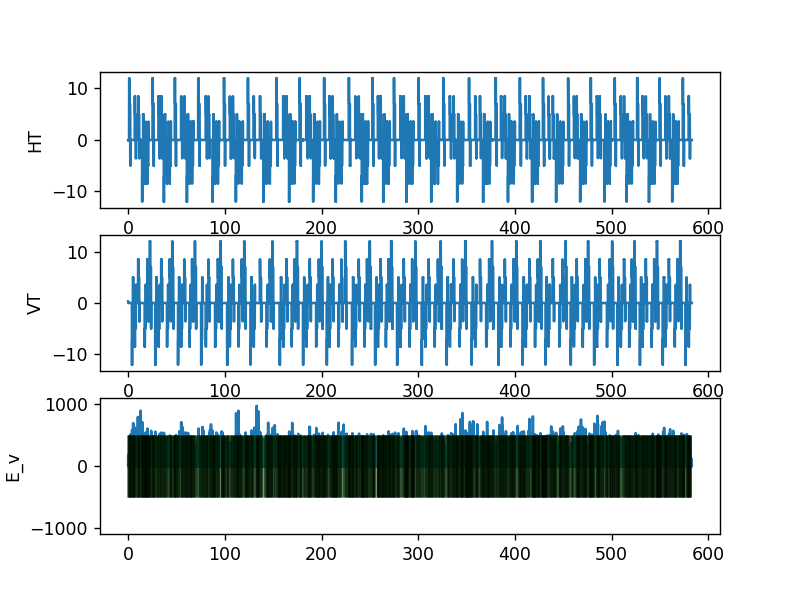

In [207]:
ax1 = plt.subplot(311)
plt.plot(t_HT, HT)
plt.ylabel('HT')
plt.subplot(312, sharex=ax1, sharey=ax1)
plt.plot(t_VT, VT)
plt.ylabel('VT')
ax3 = plt.subplot(plt.subplot(313, sharex=ax1))
plt.plot(t_VE, E_v_filtered)
plt.ylabel('E_v')
# plt.eventplot(t_VE[rising], linelengths=1000, colors='r', zorder=10, alpha = 0.4)
plt.eventplot(t_VE[saccade_onsets],linelengths=1000, colors='g', zorder=10, alpha = 0.4)
plt.eventplot(t_VE[saccade_offsets],linelengths=1000, colors='k', zorder=10, alpha = 0.4)
plt.show()


In [129]:
import gc
gc.collect()

1395